In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
# from wordcloud import WordCloud
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
survey_df = pd.read_csv('Data/survey.csv')
survey_df.head(10)

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN
5,2014-08-27 11:31:22,33,Male,United States,TN,NaN,Yes,No,Sometimes,6-25,...,Don't know,No,No,Yes,Yes,No,Maybe,Don't know,No,NaN
6,2014-08-27 11:31:50,35,Female,United States,MI,NaN,Yes,Yes,Sometimes,1-5,...,Somewhat difficult,Maybe,Maybe,Some of them,No,No,No,Don't know,No,NaN
7,2014-08-27 11:32:05,39,M,Canada,NaN,NaN,No,No,Never,1-5,...,Don't know,No,No,No,No,No,No,No,No,NaN
8,2014-08-27 11:32:39,42,Female,United States,IL,NaN,Yes,Yes,Sometimes,100-500,...,Very difficult,Maybe,No,Yes,Yes,No,Maybe,No,No,NaN
9,2014-08-27 11:32:43,23,Male,Canada,NaN,NaN,No,No,Never,26-100,...,Don't know,No,No,Yes,Yes,Maybe,Maybe,Yes,No,NaN


### Question 1: Question 1: Tình trạng sức khỏe tâm thần của nhân viên (từng giới) công ty công nghệ hiện nay như thế nào và họ quan tâm thế nào đến sức khỏe tâm thần của bản thân ?

**Mục tiêu:** Nhận biết tình trạng chung sức khỏe tâm thần chung của nhân viên công ty công nghệ, nhân viên với trạng thái tinh thần ổn định, khỏe mạnh thì mới có thể làm việc năng suất và hiệu quả nhất được. Và tính nhận thức về sức khỏe của bản thân mỗi nhân viên, bản thân còn không chăm sóc được thì làm sao có thể lo nghĩ cho công ty và phát triển về lâu dài

**Các cột sử dụng:** Gender, family_history, treatment, mental_health_interview, care_options, tech_company

**Hướng thực hiện:** 
1. Lọc lấy cái dòng dữ liệu của công ty công nghệ 
2. Xử lý cột gender trước khi sử dụng 
3. Với 3 cột Gender, family_history, treatment xem xét sức khỏe tâm thần của nhân viên theo giới 
4. Với các cột còn lại sẽ trả lời cho việc nhân viên quan tâm thế nào đến bản thân

Bước 1: Lọc lấy cái dòng dữ liệu của công ty công nghệ

In [6]:
copy_df = survey_df.copy()
copy_df = copy_df[copy_df['tech_company'] == 'Yes']
copy_df['tech_company'].value_counts()

tech_company
Yes    1031
Name: count, dtype: int64

Bước 2: Xóa bỏ cột tech_company và xử lý cột Gender trước khi khai thác

In [7]:
copy_df.drop(columns = ['tech_company'], inplace = True)

Ta xem xét các giá trị hiện hữu trong cột **Gender**

In [9]:
copy_df['Gender'].unique()

array(['Female', 'Male', 'M', 'male', 'female', 'm', 'Male-ish', 'maile',
       'Trans-female', 'Cis Female', 'F', 'something kinda male?',
       'Cis Male', 'Woman', 'Mal', 'Male (CIS)', 'f', 'queer/she/they',
       'non-binary', 'Femake', 'Make', 'Nah', 'All', 'Enby', 'fluid',
       'Genderqueer', 'Female ', 'Androgyne', 'Agender',
       'male leaning androgynous', 'Male ', 'Man', 'msle',
       'Female (trans)', 'queer', 'Female (cis)', 'Mail', 'cis male',
       'A little about you', 'Malr', 'p', 'Cis Man'], dtype=object)

In [10]:
male_vals = ['M', 'Male', 'male', 'm', 'Male-ish', 'maile', 'Mal', 'Male (CIS)', 'Make', 'Male ', 'Man', 'msle', 'Mail', 'cis male', 'Malr', 'Cis man']
female_vals = ['Female', 'female', 'F', 'Cis Female', 'Femake', 'woman', 'Female ', 'cis-female/feme', 'Female (cis)', 'femail']

def normalize_gender(gender):
    if gender in male_vals:
        return 'Male'
    elif gender in female_vals:
        return 'Female'
    else:
        return'Others'
    
copy_df['Gender'] = copy_df['Gender'].transform(normalize_gender)
copy_df['Gender'].value_counts()

Gender
Male      824
Female    176
Others     31
Name: count, dtype: int64

Bước 3: Tình hình sức khỏe tâm thần của nhân viên theo giới của các công ty công nghệ như thế nào?

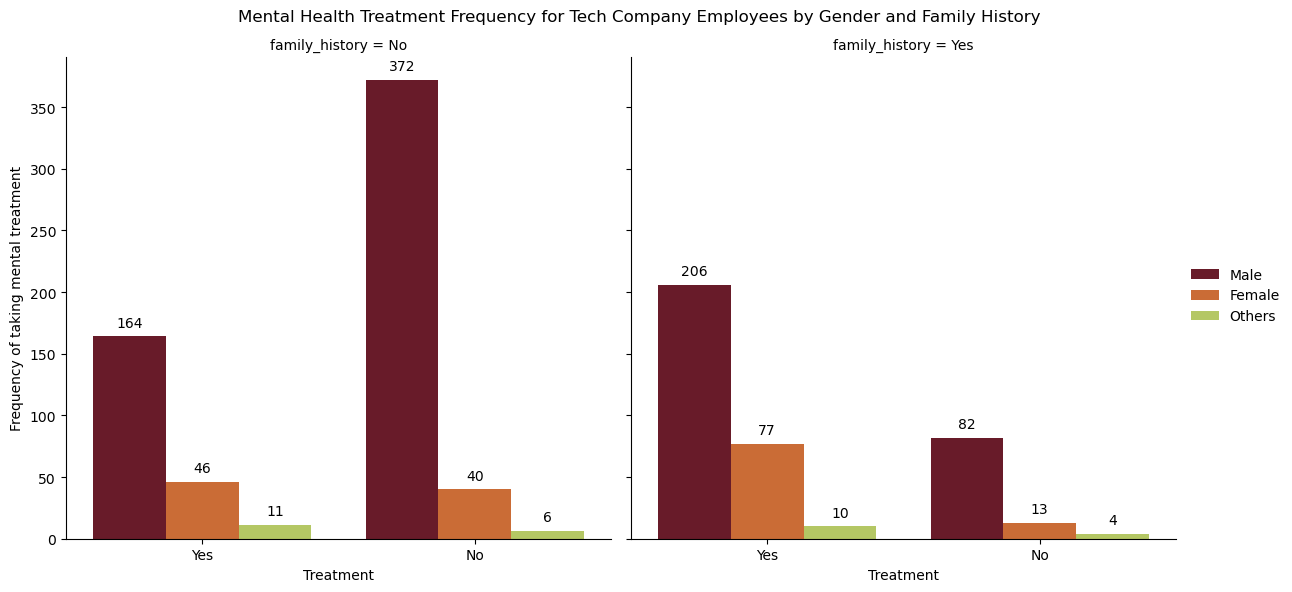

In [24]:
def annotate_bars(ax):
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', 
                    va = 'center', 
                    xytext = (0, 10), 
                    textcoords = 'offset points')

g = sns.FacetGrid(copy_df, col="family_history", height=6)
g.map(sns.countplot, 'treatment', hue=copy_df['Gender'], order=["Yes", "No"], hue_order=['Male', 'Female', 'Others'], palette = ['#750E21', '#E3651D', '#BED754'])
g.set_axis_labels('Treatment', 'Frequency of taking mental treatment')

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Mental Health Treatment Frequency for Tech Company Employees by Gender and Family History')

for ax in g.axes.flat:
    annotate_bars(ax)

g.add_legend()

plt.show()

**Kết luận 1:** 
- Nhân viên với gia đình có *tiền sử bệnh tâm thần* thì nhân viên có xu hướng đã tiếp nhận điều trị tâm thần ròi và số lượng nhiều nhất ở Nam giới, tiếp đến là Nữ giới 
- Ngược lại ở nhân viên với gia đình không có tiền sử bệnh tâm thần, việc không tiếp nhận điều trị tâm thần có số lượng rất lớn, bên cạnh đó cũng phải nhắc đến mặc dù gia đình không có tiền sử bệnh tâm thần nhưng có tổng 164 Nam giới, 46 Nữ giới, và 11 giới khác tiếp nhận điều trị tâm thần khi so sánh với giới tương ứng khi nhân viên với gia đình có tiền sử bệnh tâm thần là 206, 77, và 10

Bước 4: Sử dụng 2 cột dữ liệu mental_health_interviews và care_options để đánh giá mức độ quan tâm sức khỏe tâm thần của bản thân nhân viên. 

Cụ thể: Ta nhận thấy giá trị 'Not Sure' của cột care_options mang ý nghĩa không chắc chắn như 'Maybe' ở cột 'mental_health_interview', nên ta sẽ đưa 'Not Sure' thành 'Maybe' luôn để tiện so sánh, và vẽ đồ thị

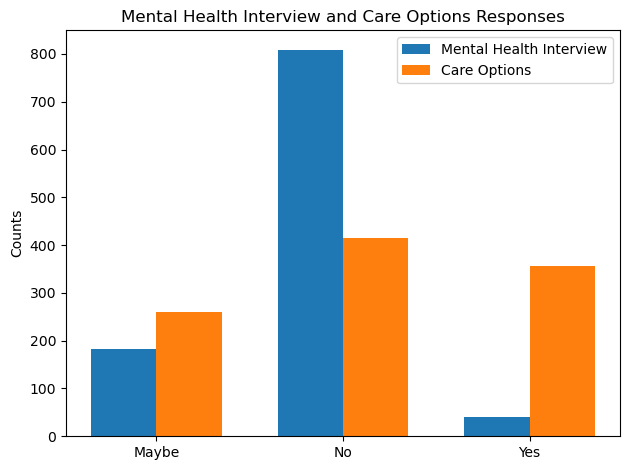

In [47]:
# replace 'Not sure' in column care_options by 'Maybe'
copy_df['care_options'] = copy_df['care_options'].replace('Not sure', 'Maybe')

mental_health_interview_counts = copy_df['mental_health_interview'].value_counts()
care_options_counts = copy_df['care_options'].value_counts()

df_counts = pd.DataFrame({'Mental Health Interview': mental_health_interview_counts, 
                          'Care Options': care_options_counts})


labels = df_counts.index
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(np.arange(len(labels)) - width/2, df_counts['Mental Health Interview'], width, label='Mental Health Interview')
rects2 = ax.bar(np.arange(len(labels)) + width/2, df_counts['Care Options'], width, label='Care Options')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Attitude towards their mental health')
ax.set_title('Mental Health Interview and Care Options Responses')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()

**Kết luận 2:** Đa số nhân viên công ty công nghệ chưa thật sự quan tâm đến sức khỏe tâm thần của bản thân khi ta có thể thấy rằng: 
- Phần lớn lựa chọn 'No' cả về việc có nêu vấn đề sức khỏe tâm thần với nhà tuyển dụng và sự hiểu biết các lựa chọn chăm sóc tâm thần của chủ lao động cung cấp 
- Nhưng ta thấy sự an ủi ở việc nhân viên cũng có biết về các lựa chọn chăm sóc được chủ lao động cung cấp (356/1031 said 'Yes') mặc dù không có ý định sẽ bàn luận trong cuộc phỏng vấn với nhà tuyển dụng tiềm năng
- 261 ý kiến cho rằng không chắc chắn là biết về các lựa chọn chăm sóc sức khỏe tâm của chủ lao động cung cấp cùng với 182 lựa chọn lưỡng lự trong việc bàn luận sức khỏe tâm thần khi tham gia phỏng vấn tuyển dụng

In [48]:
print(mental_health_interview_counts, care_options_counts)

mental_health_interview
No       809
Maybe    182
Yes       40
Name: count, dtype: int64 care_options
No       414
Yes      356
Maybe    261
Name: count, dtype: int64
